In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
from chart import show, show_collection

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure

### Spatial filtering

object type: <class 'numpy.ndarray'>
pixel type: uint8
dims: (303, 384)
size: 116352 bytes


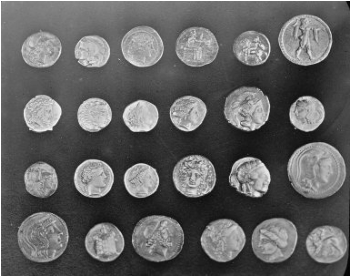

In [118]:
# Load an example image
image = data.coins()
show(image, cmap="gray", scale=0.15)
print(f"object type: {type(image)}")
print(f"pixel type: {image.dtype}")
print(f"dims: {image.shape}")
print(f"size: {image.size * image.itemsize} bytes")

#### Mean Filter Using SciPy

The following code snippet illustrates the impact of varying the kernel size ($k$) on image smoothing using the mean filter. We experimented with different kernel sizes, including $k = 1, 3, 5, 7, 15$, to observe how the filter's performance changes with different window sizes.

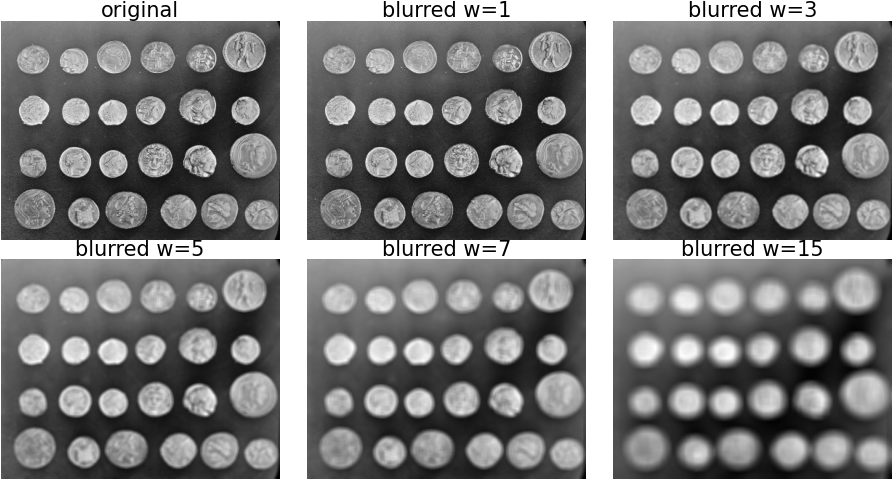

In [117]:
from scipy.ndimage import uniform_filter

# Define a list of kernel sizes for uniform filtering
kernel_sizes = [1, 3, 5, 7, 15]

# Apply uniform filtering with different kernel sizes
# Create a list 'blurred' containing the filtered images for each kernel size
blurred = [uniform_filter(image, size=kernel_size) for kernel_size in kernel_sizes]

# Display a collection of images: original and blurred images with different kernel sizes
# Titles are provided for each image
show_collection(
    [image] + blurred,  # Concatenate the original image with the blurred images
    titles=["original"] + [f"blurred w={kernel_size}" for kernel_size in kernel_sizes],  # Titles for each image
    scale=0.08,  # Scale for display
    cmap="gray",  # Colormap (grayscale)
    fontsize=15,  # Font size for titles
    num_cols=3,  # Number of columns in the display
)

#### Mean and gaussian filtetring

In this example, we demonstrate the application of mean and Gaussian low-pass filtering using both scikit-image and SciPy libraries. These filtering techniques are essential for tasks such as noise reduction and smoothing in image processing.

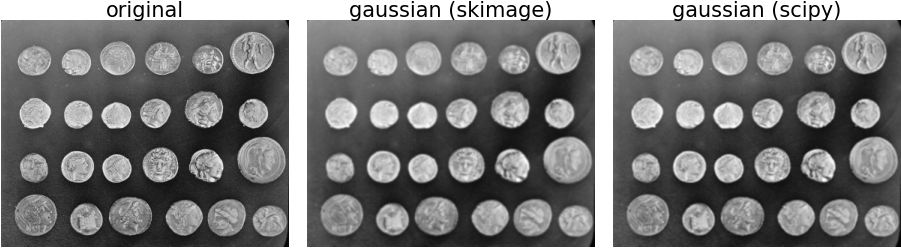

In [110]:
from scipy.ndimage import gaussian_filter
from skimage.filters import rank, gaussian

# Define the kernel size and sigma for Gaussian filtering
kernel_size = 3
sigma = 1.0

# Mean filter
# Create a kernel of ones with the specified size
kernel = np.ones((kernel_size, kernel_size))
# Apply the mean filter to the image
blurred_mean = rank.mean(image, kernel)

# Gaussian filtering using skimage's gaussian function
# Gaussian function in scikit-image is a wrapper around scipy.ndimage.gaussian_filter()
# Kernel size is determined based on the specified sigma.
blurred_gauss_skimage = gaussian(image, sigma=sigma)

# Gaussian filtering using scipy's gaussian_filter function
# Specify the kernel size explicitly based on sigma and kernel size.
blurred_gauss_scipy = gaussian_filter(image, sigma=sigma, radius=((kernel_size - 1) // 2))

# Display a collection of images: original, Gaussian (skimage), and Gaussian (scipy)
# Titles are provided for each image
show_collection(
    [image, blurred_gauss_skimage, blurred_gauss_scipy],
    titles=["original", "gaussian (skimage)", "gaussian (scipy)"],
    scale=0.08,  # Scale for display
    cmap="gray",  # Colormap (grayscale)
    fontsize=15  # Font size for titles
)


#### Arbitrary convolution using scipy

In this example, we'll use SciPy's `ndimage.correlate` function to perform a "convolution" operation (remember the discussion on kernel symmetry). Specifically, we'll be applying the Prewitt filter to enhance the edges in an image in the horizontal direction. Convolution is a fundamental technique in image processing, allowing us to emphasize features like edges by applying a filter or kernel to the image's pixel values.

Image Statistics Report:
- Mean Value: -0.69
- Median Value: 0.00
- Standard Deviation: 67.66
- Minimum Value: -562.00
- Maximum Value: 562.00


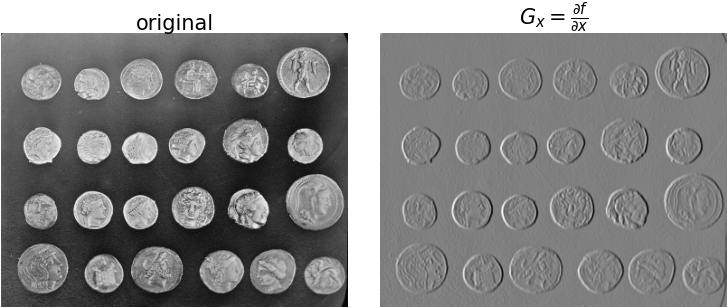

In [116]:
from scipy.ndimage import correlate

# Define the Prewitt kernel for horizontal edges
kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])

# "Convolve" the image with the Prewitt kernel to calculate horizontal gradients (partial derivative with respect to x)
gx = correlate(image.astype(float), kernel_x)

# Print the statistics report for the horizontal gradient image
print("Image Statistics Report:")
print("- Mean Value: {:.2f}".format(np.mean(gx)))
print("- Median Value: {:.2f}".format(np.median(gx)))
print("- Standard Deviation: {:.2f}".format(np.std(gx)))
print("- Minimum Value: {:.2f}".format(np.min(gx)))
print("- Maximum Value: {:.2f}".format(np.max(gx)))

# Display a collection of images: original and horizontal gradient
# Titles are provided for each image
show_collection([image.astype(int), gx], titles=["original", "$G_x=\\frac{\\partial f}{\\partial x}$"], cmap="gray", scale=0.1, fontsize=15)

#### Median filtering

Median filtering is a widely-used image processing technique employed to reduce noise while preserving edges. This method involves calculating the median value of pixels within a sliding window and assigning this median value to the central pixel. It helps reduce noise without overly smoothing image features.

Median filtering effectively removes noise while preserving edges and image details. It is particularly useful in scenarios with salt-and-pepper noise, where isolated white and black pixels (noise) can be eliminated without significantly affecting the rest of the image.

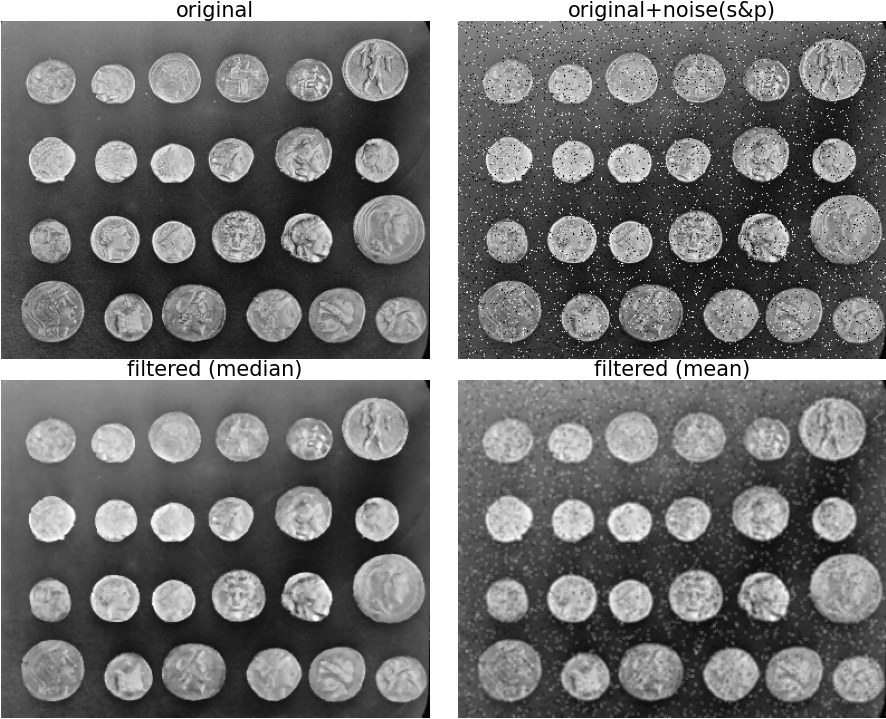

In [112]:
from skimage.util import random_noise
from scipy.ndimage import median_filter
from skimage.filters.rank import mean
from skimage.morphology import square

# Add salt and pepper noise to the image
# https://scikit-image.org/docs/stable/api/skimage.util.html#skimage.util.random_noise
# 'mode' specifies the type of noise, and 'amount' controls the noise level
noisy = random_noise(image, mode="s&p", amount=0.05)  # Adjust the amount as needed

# Apply median filter to remove noise
# Median filter replaces each pixel's value with the median value in its neighborhood
# 'size' determines the size of the neighborhood (kernel size)
filtered_median = median_filter(noisy, size=3)  # Adjust the kernel size as needed

# Apply mean filter to remove noise
# Mean filter replaces each pixel's value with the mean (average) value in its neighborhood
# 'kernel' specifies the shape of the neighborhood (square in this case)
filtered_mean = mean(noisy, square(3))  # Adjust the kernel size as needed

# Display a collection of images: original, noisy, filtered (median), filtered (mean)
# Titles are provided for each image
show_collection(
    [image, noisy, filtered_median, filtered_mean],
    titles=["original", "original+noise(s&p)", "filtered (median)", "filtered (mean)"],
    scale=0.12,  # Scale for display
    cmap="gray",  # Colormap (grayscale)
    fontsize=15,  # Font size for titles
    num_rows=2,  # Number of rows in the display
)


#### Laplacian

The Laplacian operator $\nabla^2 f$ is used to calculate the second derivative of a function $f(x, y)$ with respect to both $x$ and $y$. It is defined as follows:

$$
\nabla^2 f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}
$$

##### Enhancement

To enhance an image using the Laplacian operator, we can use the following enhancement formula:

$$
g(x, y) = f(x, y) + c\cdot\nabla^2 f
$$

Where:
- $g(x, y)$ is the enhanced image.
- $f(x, y)$ is the original image.
- $\nabla^2 f$ is the Laplacian of the original image, which highlights edges and details.
- $c$ is a constant that controls the strength of the enhancement. Adjusting $c$ can fine-tune the enhancement effect.


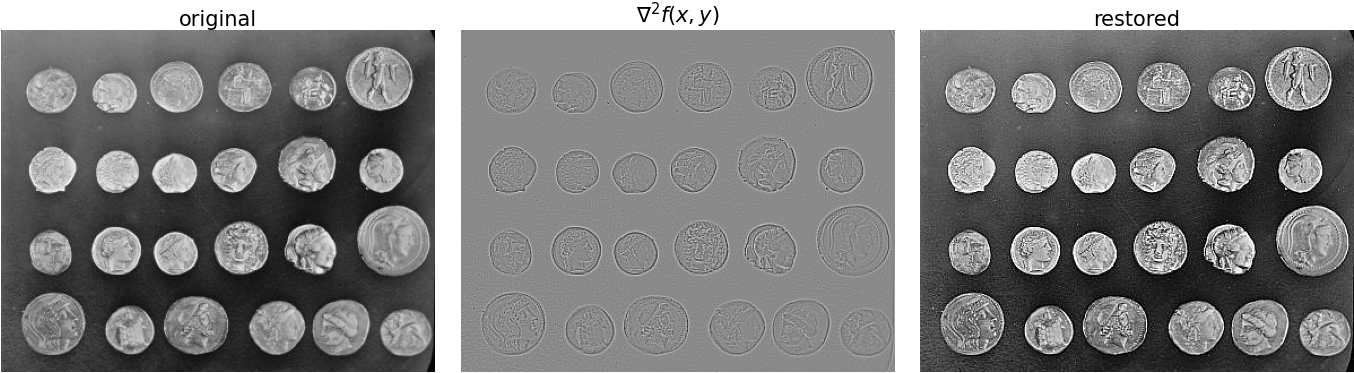

In [104]:
# Define a 3x3 kernel for the Laplacian operator
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=int)

# Apply the Laplacian operator to the image using correlation
# This calculates the second derivative of the image, emphasizing edges and details
laplacian = correlate(image.astype(int), kernel)

# Define a constant 'c' to control the strength of the restoration effect
c = -0.2

# Perform restoration by adding the scaled Laplacian to the original image
restored = image.astype(int) + c * laplacian

# Clip pixel values to ensure they remain within the valid range (0 to 255)
restored = np.clip(restored, 0, 255)

# Display a collection of images: original, Laplacian, and restored
# The titles are displayed above each image
show_collection([image, laplacian, restored], titles=["original", "$\\nabla^2 f(x, y)$", "restored"], cmap="gray", scale=0.12, fontsize=15)

### A scikit-image example


Ref.: https://scikit-image.org/docs/stable/auto_examples/filters/plot_rank_mean.html#sphx-glr-auto-examples-filters-plot-rank-mean-py

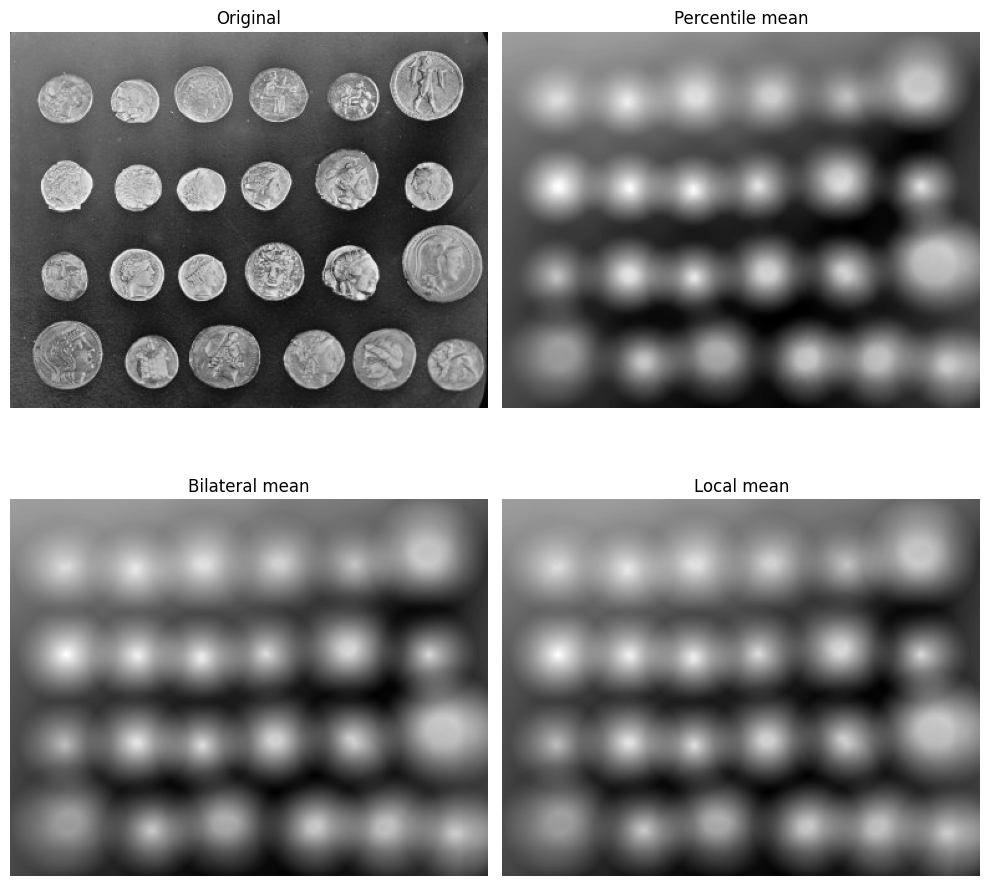

In [ ]:
import matplotlib.pyplot as plt

from skimage import data
from skimage.morphology import disk
from skimage.filters import rank


image = data.coins()
footprint = disk(20)

percentile_result = rank.mean_percentile(image, footprint=footprint, p0=0.1, p1=0.9)
bilateral_result = rank.mean_bilateral(image, footprint=footprint, s0=500, s1=500)
normal_result = rank.mean(image, footprint=footprint)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

titles = ["Original", "Percentile mean", "Bilateral mean", "Local mean"]
imgs = [image, percentile_result, bilateral_result, normal_result]
for n in range(0, len(imgs)):
    ax[n].imshow(imgs[n], cmap=plt.cm.gray)
    ax[n].set_title(titles[n])
    ax[n].axis("off")

plt.tight_layout()
plt.show()